## plot before loading model weights
581


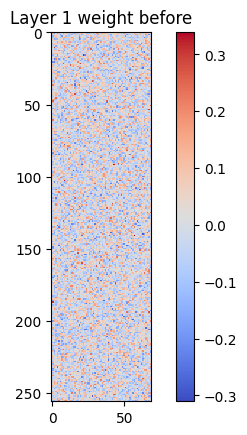

/tmp/ipykernel_1096267/1898085545.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load('./models/SmallLowGearAntTRP-v0__ppo__0__1741093440.p

Agent(
  (critic): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): BetaHead(
      (fcc_c0): Linear(in_features=256, out_features=8, bias=True)
      (fcc_c1): Linear(in_features=256, out_features=8, bias=True)
    )
  )
)
torch.Size([256, 69])


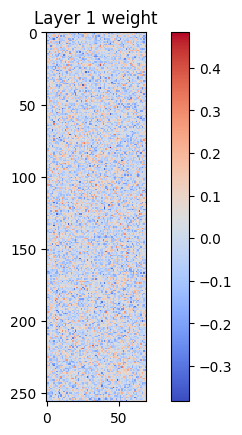

581


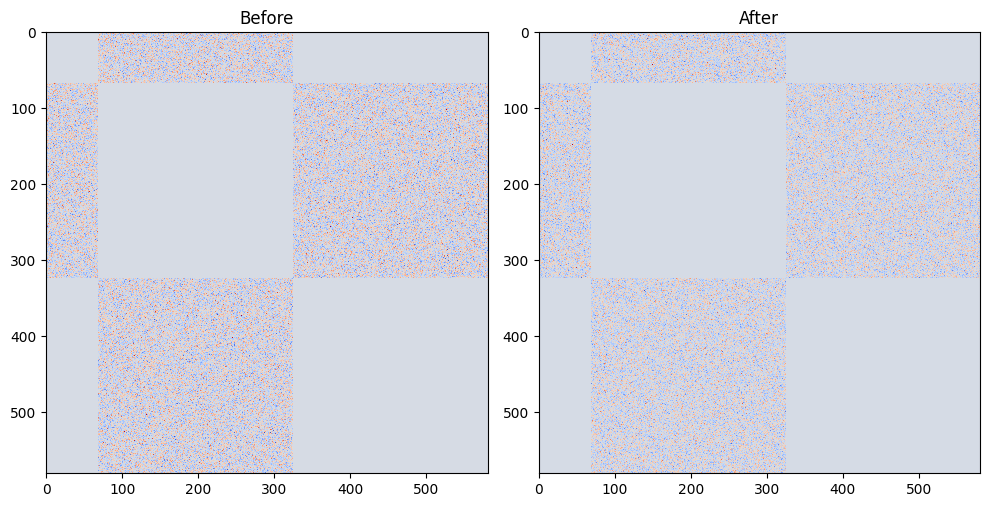

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from util import layer_init, BetaHead, make_env

import gym
import trp_env
import tiny_homeostasis
import thermal_regulation

def create_connectivity_matrix(layers: nn.Sequential):
    
	total_neurons = 0
	for layer in layers:
		if isinstance(layer, nn.Linear):
			# layer = layers[i]
			total_neurons += layer.out_features
		
	total_neurons += layers[0].in_features
	print(total_neurons)
    # total_neurons =
	C = np.zeros((total_neurons, total_neurons))

	start_idx = 0  # Index of first neuron in the current layer
	for layer in layers:
		# layer = layers[i]
		if isinstance(layer, nn.Linear):
			C[start_idx:start_idx + layer.in_features, start_idx + layer.in_features:start_idx + layer.in_features + layer.out_features] = layer.weight.T.detach().numpy()
			C.T[start_idx:start_idx + layer.in_features, start_idx + layer.in_features:start_idx + layer.in_features + layer.out_features] = layer.weight.T.detach().numpy()
			start_idx += layer.in_features
   
	return C

class Agent(nn.Module):
	def __init__(self, envs, gaussian=False):
		super().__init__()

		self.is_gaussian = gaussian

		self.critic = nn.Sequential(
			layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
			nn.Tanh(),
			layer_init(nn.Linear(256, 256)),
			nn.Tanh(),
			layer_init(nn.Linear(256, 1), std=1.0),
		)

		self.actor = nn.Sequential(
			layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
			nn.Tanh(),
			layer_init(nn.Linear(256, 256)),
			nn.Tanh(),
			BetaHead(256, np.prod(envs.single_action_space.shape)),
		)

	def get_value(self, x):
		return self.critic(x)

	def get_action_and_value(self, x, action=None):
		probs = self.actor(x)
		if action is None:
			action = probs.sample()
		return action, probs.log_prob(action), probs.entropy(), self.critic(x)

seed_ = (1 + 1) * 1
envs = gym.vector.SyncVectorEnv(
    [make_env(env_id='SmallLowGearAntTRP-v0',
                seed=seed_ + i,
                idx=i,
                capture_video=False,
                run_name='test',
                max_episode_steps=60_000,
                gaussian_policy=False) for i in range(1)]
)

agent = Agent(envs=envs, gaussian=False)

print("## plot before loading model weights")
C1 = create_connectivity_matrix(agent.actor)
layer1_before = agent.actor[0]
plt.imshow(layer1_before.weight.detach().numpy(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Layer 1 weight before')
plt.show()
#load the model
agent.load_state_dict(torch.load('./models/SmallLowGearAntTRP-v0__ppo__0__1741093440.pth'))
print(agent)

layer1 = agent.actor[0]
print(layer1.weight.shape)
# plot the weight as a matrix
plt.imshow(layer1.weight.detach().numpy(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Layer 1 weight')
plt.show()

C2 = create_connectivity_matrix(agent.actor)

#plot before and after side by side with same scale
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(C1, cmap='coolwarm', interpolation='nearest')
axs[0].set_title('Before')
axs[1].imshow(C2, cmap='coolwarm', interpolation='nearest')
axs[1].set_title('After')
plt.tight_layout()
# plt.savefig('connectivity_before_vs_after.png')
plt.show()
